The data-preprocessing part is from Oscar Gilg

This is a neural network attempts for classifying data of tradeteq. The data-preprocessing part is all written by Oscar Gilg, together with the assumptions for data cleansing. 
The rest of the neural network model design and analysis is done by Xingyue Huang.

In [1]:
import pandas as pd
import numpy as np
import os
import keras

In [2]:
# Read the sample file
co_file = "Co_600K_Jul2019_6M.pkl"
df_co = pd.read_pickle(co_file)

In [3]:
df_co.head(5)

,AccountsAccountCategory,AccountsAccountRefDay,AccountsAccountRefMonth,CompanyCategory,CompanyId,CompanyName,CompanyNameCountNum,CompanyNameCountX,CompanyNameLen,CompanyNameWordLen,...,namechanged,namechanged2,oa11,oac1,oac11,oac2,oseast1m,osnrth1m,pcd,ru11ind
2993,TOTAL EXEMPTION FULL,31,3,Private Limited Company,352482,ATLANTIC BAY HOTEL (WOOLACOMBE) LIMITED,0,0,39,5,...,0,0,E00054910,5,5A1,5A,411310.0,421493.0,HX59DG,A1
3969,DORMANT,30,11,Private Limited Company,3477508,SUPERIOR PROPERTY INVESTMENTS LTD,0,0,33,4,...,0,0,E00166435,2,2C1,2C,392203.0,173252.0,SN153HR,C1
6752,TOTAL EXEMPTION FULL,30,11,Private Limited Company,1509998,GLP OLD STREET LIMITED,0,0,22,4,...,0,0,E00024130,2,2B2,2B,529221.0,181386.0,W1W8DW,A1
15331,TOTAL EXEMPTION FULL,31,12,Private Limited Company,410035,BAMFORD BROOK APARTMENTS LTD,0,0,28,4,...,0,0,E00025340,4,4A1,4A,378356.0,407292.0,M263WQ,A1
18593,TOTAL EXEMPTION FULL,28,2,Private Limited Company,915950,CREATIVE DIGITAL PRINTING SOLUTIONS LIMITED,0,0,43,5,...,0,0,E00149681,5,5A1,5A,399770.0,311242.0,WS117GB,A1


In [4]:
print(df_co.isnull().sum())

AccountsAccountCategory       0
AccountsAccountRefDay         4
AccountsAccountRefMonth       4
CompanyCategory               0
CompanyId                     0
                           ... 
oac2                          0
oseast1m                      0
osnrth1m                      0
pcd                           0
ru11ind                    8708
Length: 131, dtype: int64


In [5]:
print("   Column                         No of unique values")
for n,c in enumerate(df_co.columns):
    print("{:3d}. {:<35}: {:>6}".format(n,c, len(df_co[c].unique())))
    print("Number of nans: ", df_co[c].isnull().sum())
    print("type of data: ", type(df_co[c][0]))
    print()

   Column                         No of unique values
  0. AccountsAccountCategory            :     16
Number of nans:  0
type of data:  <class 'str'>

  1. AccountsAccountRefDay              :     32
Number of nans:  4
type of data:  <class 'str'>

  2. AccountsAccountRefMonth            :     13
Number of nans:  4
type of data:  <class 'str'>

  3. CompanyCategory                    :      2
Number of nans:  0
type of data:  <class 'str'>

  4. CompanyId                          : 600000
Number of nans:  0
type of data:  <class 'numpy.int64'>

  5. CompanyName                        : 600000
Number of nans:  0
type of data:  <class 'str'>

  6. CompanyNameCountNum                :     16
Number of nans:  0
type of data:  <class 'numpy.int64'>

  7. CompanyNameCountX                  :      5
Number of nans:  0
type of data:  <class 'numpy.int64'>

  8. CompanyNameLen                     :     85
Number of nans:  0
type of data:  <class 'numpy.int64'>

  9. CompanyNameWordLen         

 83. hasF1014                           :      2
Number of nans:  0
type of data:  <class 'numpy.int32'>

 84. hasF1129                           :      2
Number of nans:  0
type of data:  <class 'numpy.int32'>

 85. hasF1522                           :      2
Number of nans:  0
type of data:  <class 'numpy.int32'>

 86. hasF1631                           :      2
Number of nans:  0
type of data:  <class 'numpy.int32'>

 87. hasF17                             :      2
Number of nans:  0
type of data:  <class 'numpy.int32'>

 88. hasF1865                           :      2
Number of nans:  0
type of data:  <class 'numpy.int32'>

 89. hasF1871                           :      2
Number of nans:  0
type of data:  <class 'numpy.int32'>

 90. hasF1885                           :      2
Number of nans:  0
type of data:  <class 'numpy.int32'>

 91. hasF1977                           :      2
Number of nans:  0
type of data:  <class 'numpy.int32'>

 92. hasF2298                           :     

To do list for dealing with features:

Ideas:

- Drop company Id
- Drop Company Number (unless it's easy to change)

To investigate:

- CompanyName
- All the FieldXXX which have more than 500 unique values
- PreviousName_1CompanyName       
- RegAddressAddressLine1          
- RegAddressAddressLine2         
- RegAddressCareOf                 
- RegAddressCounty                
- RegAddressPOBox                 
- RegAddressPostCode               
- RegAddressPostTown                                          
- oa11: need more info on what it represents
- pcd: need more info on what it represents           
Some other features are not numerical but have a small number of unique values and can therefore be encoded using standard techniques.


Try removing problematic features for now

In [6]:
zero_info_features = ["CompanyId", "CompanyNumber"]
only_one_value_features = ["Filled", "LimitedPartnershipsNumGenPartners", "LimitedPartnershipsNumLimPartners",\
                          "Status20190701"]
complicated_features = ["RegAddressAddressLine1", "RegAddressAddressLine2", "RegAddressCareOf", "RegAddressCounty", \
                        "RegAddressPOBox", "RegAddressPostCode", "RegAddressPostTown", "pcd", "oa11", "PreviousName_1CompanyName"]


In [7]:
df_curated = df_co.drop(zero_info_features + only_one_value_features + complicated_features, axis=1)

Encoding the categorical data

In [8]:
import numbers

In [9]:
def is_numeric(column):
    i = 0
    while i < len(column) and column[i] is None:
        i += 1
    if i == len(column):
        return "Cannot infer"
    return isinstance(column[i], numbers.Number)

In [10]:
def extract_categorical_feature_names(df):
    return [col for col in df if not is_numeric(df[col].values)]

In [11]:
df_curated["ru11ind"].unique()

array(['A1', 'C1', 'D2', 'F1', 'B1', 'D1', 'E1', 'F2', 'C2', nan, 1.0,
       '1', '2', 2.0, '4', 3.0, '8', '6', 7.0, 'E2', 6.0, '7', '3', '5',
       4.0, 8.0], dtype=object)

In [12]:
# modifies df
def convert_col_to(df, to_cols, func):
    for col in to_cols:
        df[col] = df[col].apply(lambda x: func(x) if x is not None else None)
#Here is a bug from the original code: it should be to_cols in the for loop

In [13]:
to_int_cols = ["AccountsAccountRefDay", "AccountsAccountRefMonth", "oac1"]
convert_col_to(df_curated, to_int_cols, int)

In [14]:
# Change None to string 'Nan' so that it is encoded with sklearn LabelEncoder
for cat in extract_categorical_feature_names(df_curated):
    df_curated[cat] = df_curated[cat].apply(lambda x: 'Nan' if x is None else x)

In [15]:
convert_col_to(df_curated, ["ru11ind"], str)

In [16]:
df_curated["ru11ind"].unique()

array(['A1', 'C1', 'D2', 'F1', 'B1', 'D1', 'E1', 'F2', 'C2', 'nan', '1.0',
       '1', '2', '2.0', '4', '3.0', '8', '6', '7.0', 'E2', '6.0', '7',
       '3', '5', '4.0', '8.0'], dtype=object)

In [17]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [18]:
cat_features = extract_categorical_feature_names(df_curated)
encoded_data = pd.concat([df_curated.drop(cat_features, axis=1), df_curated[cat_features].apply(le.fit_transform)], axis=1)

In [19]:
encoded_data['cty']

2993       26
3969       26
6752       26
15331      26
18593      20
           ..
3195120     8
929546      0
2794558    26
1475053    26
3145186    13
Name: cty, Length: 600000, dtype: int64

In [20]:
from sklearn.model_selection import train_test_split
X, y = encoded_data.drop('isfailed',axis = 1), encoded_data['isfailed'].values
X = keras.utils.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,random_state=2020)

Now we adopt the normal neural network and trains with 3 hidden layers,and dropout layers in between, and l1 regularizer to avoid overfitting. Also we applied gradient clipping in the optimizer to ensure it does not experience gradient explode.

In [21]:
print(X_train.shape)

(480000, 114)


In [22]:
y_train.shape

(480000,)

In [23]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten

In [24]:
# define the keras model
model = Sequential()
model.add(Dense(240,input_dim=114 ,activation = 'relu',kernel_regularizer='l1'))
model.add(Dropout(.2))
model.add(Dense(60, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
# compile the keras model
opt = keras.optimizers.Adam(lr=0.01, clipnorm=1.0)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [26]:
history = model.fit(X_train, y_train, epochs=2, validation_data = (X_test,y_test),batch_size=10)

Epoch 1/2
48000/48000 [==============================] - 51s 1ms/step - loss: nan - accuracy: 0.9980 - val_loss: nan - val_accuracy: 0.9982
Epoch 2/2
48000/48000 [==============================] - 49s 1ms/step - loss: nan - accuracy: 0.9980 - val_loss: nan - val_accuracy: 0.9982


Now we plot the model and find the training accuracy 

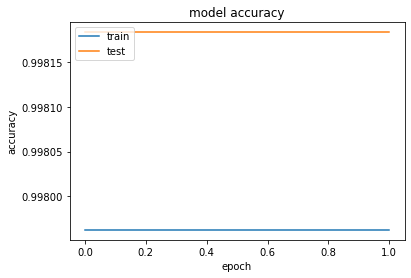

<Figure size 432x288 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()
plt.savefig("ANNtrain.png")

We can see that this is already well-trained with accuracy approachingt to 99.8%